In [1]:
import h5py
import numpy as np
import pandas as pd
from datasets import load_dataset
from time import time
from tqdm import tqdm
from collections import Counter

In [2]:
ds = load_dataset('Artificio/WikiArt', split='train')
print('ds loaded')

README.md:   0%|          | 0.00/663 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

(…)-00000-of-00004-3c65976b59bc0ab4.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

(…)-00001-of-00004-441bd829579dead0.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

(…)-00002-of-00004-7b0bbb36fb350222.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

(…)-00003-of-00004-971fec8ddd44fece.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103250 [00:00<?, ? examples/s]

ds loaded


In [3]:
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

split_data = ds.train_test_split(test_size=(valid_ratio + test_ratio), shuffle=True, seed=42)

train_data = split_data['train']
temp_data = split_data['test']

split_data = temp_data.train_test_split(test_size=test_ratio / (valid_ratio + test_ratio), shuffle=True, seed=42)

valid_data = split_data['train']
test_data = split_data['test']

In [4]:
train_df = train_data.to_pandas()
train_df['set_type'] = 'train'
train_df['h5_index'] = range(len(train_df))

valid_df = valid_data.to_pandas()
valid_df['set_type'] = 'val'
valid_df['h5_index'] = range(len(train_df), len(train_df) + len(valid_df))

test_df = test_data.to_pandas()
test_df['set_type'] = 'test'
test_df['h5_index'] = range(len(train_df) + len(valid_df), len(train_df) + len(valid_df) + len(test_df))

all_data = pd.concat([train_df, valid_df, test_df])

annotations = all_data[['h5_index', 'set_type', 'artist', 'genre', 'style']]

In [5]:
def save_to_h5(filename, datasets, image_shape=(3, 224, 224), batch_size=6000):
    num_images = sum(len(data) for data in datasets.values())
    with h5py.File(filename, 'w') as h5f:
        h5_dataset = h5f.create_dataset('image', shape=(num_images, *image_shape), dtype='uint8')
        
        index = 0
        for set_type, dataset in datasets.items():
            for i in tqdm(range(0, len(dataset), batch_size), desc=f'Processing {set_type}'):
                batch_images = dataset[i:i + batch_size]['image']
                print(f'{set_type} {filename} batch {(i/batch_size) + 1}') # for kaggle log
                batch_data = [
                    np.array(img.resize((224, 224)).convert('RGB'), dtype=np.uint8).transpose(2, 0, 1)
                    for img in batch_images
                ]
                batch_size_actual = len(batch_data)
                h5_dataset[index:index + batch_size_actual] = batch_data
                index += batch_size_actual

In [6]:
groups = {'train': train_data, 'val': valid_data, 'test': test_data}
save_to_h5('/kaggle/working/dataset.h5', groups)

print('dataset.h5 has been saved.')

Processing train:   0%|          | 0/14 [00:00<?, ?it/s]

train /kaggle/working/dataset.h5 batch 1.0


Processing train:   7%|▋         | 1/14 [00:19<04:08, 19.11s/it]

train /kaggle/working/dataset.h5 batch 2.0


Processing train:  14%|█▍        | 2/14 [00:37<03:44, 18.68s/it]

train /kaggle/working/dataset.h5 batch 3.0


Processing train:  21%|██▏       | 3/14 [00:55<03:22, 18.39s/it]

train /kaggle/working/dataset.h5 batch 4.0


Processing train:  29%|██▊       | 4/14 [01:12<02:58, 17.90s/it]

train /kaggle/working/dataset.h5 batch 5.0


Processing train:  36%|███▌      | 5/14 [01:29<02:37, 17.46s/it]

train /kaggle/working/dataset.h5 batch 6.0


Processing train:  43%|████▎     | 6/14 [01:46<02:18, 17.25s/it]

train /kaggle/working/dataset.h5 batch 7.0


Processing train:  50%|█████     | 7/14 [02:03<02:00, 17.15s/it]

train /kaggle/working/dataset.h5 batch 8.0


Processing train:  57%|█████▋    | 8/14 [02:20<01:42, 17.07s/it]

train /kaggle/working/dataset.h5 batch 9.0


Processing train:  64%|██████▍   | 9/14 [02:37<01:25, 17.16s/it]

train /kaggle/working/dataset.h5 batch 10.0


Processing train:  71%|███████▏  | 10/14 [02:54<01:08, 17.08s/it]

train /kaggle/working/dataset.h5 batch 11.0


Processing train:  79%|███████▊  | 11/14 [03:11<00:51, 17.02s/it]

train /kaggle/working/dataset.h5 batch 12.0


Processing train:  86%|████████▌ | 12/14 [03:27<00:33, 16.93s/it]

train /kaggle/working/dataset.h5 batch 13.0


Processing train:  93%|█████████▎| 13/14 [03:44<00:16, 16.84s/it]

train /kaggle/working/dataset.h5 batch 14.0


Processing val:   0%|          | 0/2 [00:00<?, ?it/s]

val /kaggle/working/dataset.h5 batch 1.0


Processing val:  50%|█████     | 1/2 [00:17<00:17, 17.01s/it]

val /kaggle/working/dataset.h5 batch 2.0


Processing test:   0%|          | 0/2 [00:00<?, ?it/s]

test /kaggle/working/dataset.h5 batch 1.0


Processing test:  50%|█████     | 1/2 [00:16<00:16, 16.92s/it]

test /kaggle/working/dataset.h5 batch 2.0


Processing test: 100%|██████████| 2/2 [00:28<00:00, 14.32s/it]

dataset.h5 has been saved.


In [7]:
annotations.to_csv('/kaggle/working/annotations.csv', index=False)

print('annotations.csv has been saved.')

annotations.csv has been saved.


In [8]:
from torch.utils.data import Dataset, DataLoader
import torch

class WikiArtDataset(Dataset):
    def __init__(self, h5_path: str, csv_path: str, set_type: str, label_col='style', transform=None):
        self.h5_path = h5_path        
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['set_type'] == set_type]
        self.label_col = label_col
        self.transform = transform
        self.length = len(self.df)

    def __len__(self):
        return self.length

    def _open_hdf5(self):
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')
    
    def __getitem__(self, idx):
        self._open_hdf5()

        row = self.df.iloc[idx]
        image_idx = row['h5_index']
        
        label = row[self.label_col]

        image = self._hf['image'][image_idx]
        image = torch.from_numpy(image).float() / 255

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
train_ds = WikiArtDataset('/kaggle/working/dataset.h5', '/kaggle/working/annotations.csv', 'val', label_col='artist')

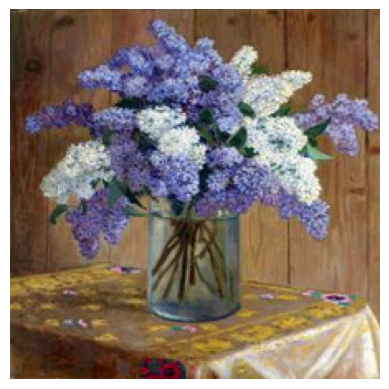

Nikolay Bogdanov-Belsky


In [10]:
import matplotlib.pyplot as plt

image, label = train_ds[100]

image = image.detach().numpy().transpose(1, 2, 0)

plt.imshow(image)
plt.axis('off')
plt.show()

print(label)

In [11]:
train_ds.df

,h5_index,set_type,artist,genre,style
82600,82600,val,Cuno Amiet,landscape,Post-Impressionism
82601,82601,val,James Ensor,marina,Impressionism
82602,82602,val,Erte,design,Art Deco
82603,82603,val,Frits Thaulow,landscape,Impressionism
82604,82604,val,Lavinia Fontana,portrait,Mannerism (Late Renaissance)
...,...,...,...,...,...
92920,92920,val,Henri Fantin-Latour,flower painting,Realism
92921,92921,val,Walter Sickert,still life,Impressionism
92922,92922,val,Gregoire Boonzaier,still life,Post-Impressionism
92923,92923,val,Fikret Mualla Saygi,genre painting,Fauvism
